# Model-Based Design of Experiments

This notebook is based on an example from:

[Jialu Wang](https://github.com/jialuw96) and [Alexander Dowling](https://github.com/adowling2) (2022), [Pyomo.DoE: An Open-Source Package for Model-Based Design of Experiments in Python](https://aiche.onlinelibrary.wiley.com/doi/full/10.1002/aic.17813) . *AIChE Journal*, 68(12), e17813.


## Learning Objectives
* Practice nonlinear regression basics on a reaction kinetics example
* Interpret eigendecomposition of Fisher information matrix to determine which paramters (if any) are not identifiable
* Use A-, D-, and E-optimality to recommend the next experiment that maximizes information gain

## Import Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import scipy.linalg as linalg
from matplotlib import cm

## Mathematical Model for Reaction Kinetics Example

Consider two chemical reactions that convert molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goal is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmasuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

The concenration in a **batch reactor** evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [2]:
def batch_rxn_model(theta, t, CA0, T):
    '''
    
    Predict batch reaction performance
    
    Arugments:
        t: time, [hour], scalar or Numpy array
        theta: fitted parameters: A1, A2, E1, E2
        CA0: initial concentration, [mol/L], scalar or numpy array
        T: temperature, [K], scalar or Numpy array
    Returns:
        CA, CB, CC: Concentrations at times t, [mol/L], three scalars or numpy arrays
    '''
    
    def kinetics(A, E, T):
        ''' Computes kinetics from Arrhenius equation
        Arguments:
            A: pre-exponential factor, [1 / hr]
            E: activation energy, [kJ / mol]
            T: temperature, [K]
        Returns:
            k: reaction rate coefficient, [1/hr] or [1/hr*L/mol]
        '''
        R = 8.31446261815324 # J / K / mole

        return A * np.exp(-E*1000/(R*T))

    # units: [1/hr]
    k1 = kinetics(theta[0], theta[2], T)

    # units: [1/hr]
    k2 = kinetics(theta[1], theta[3], T)

    # units: [mol / L]
    CA = CA0 * np.exp(-k1*t);
    CB = k1*CA0/(k2-k1) * (np.exp(-k1*t) - np.exp(-k2*t));
    CC = CA0 - CA - CB;

    return CA, CB, CC


Now let's test the code by running it.

In [3]:
theta_true = [85., 370., 7.5, 15]
time_exp = np.linspace(0,1,11) # hr
CA0_exp1 = 1.0 # mol/L
T_exp1 = 400 # K
CA_exp1, CB_exp1, CC_exp1 = batch_rxn_model(theta_true, time_exp, CA0_exp1, T_exp1)

## Generate Synthetic Experimental Dataset

Let's construct a dataset containing: 
* Batch experiment at $T=400$ K and $C_{AO}=1.0$ mol/L
* Batch experiment at $T=300$ K and $C_{AO}=3.0$ mol/L

We also simulated the first experiment. Let's simulate the second.

In [4]:
theta_true = [85., 370., 7.5, 15]
CA0_exp2 = 3.0 # mol/L
T_exp2 = 300 # K
CA_exp2, CB_exp2, CC_exp2 = batch_rxn_model(theta_true, time_exp, CA0_exp2, T_exp2)

Next let's add random normally distributed noise.

In [5]:
n_time = len(time_exp)

noise_std_dev = 0.05

CA_exp1 += noise_std_dev*np.random.normal(size=n_time)
CA_exp2 += noise_std_dev*np.random.normal(size=n_time)
CB_exp1 += noise_std_dev*np.random.normal(size=n_time)
CB_exp2 += noise_std_dev*np.random.normal(size=n_time)
CC_exp1 += noise_std_dev*np.random.normal(size=n_time)
CC_exp2 += noise_std_dev*np.random.normal(size=n_time)

Now we'll package these into a numpy array:

In [6]:
# Create empty array for experiment 1
exp1 = np.zeros((n_time,7))

# Assign 1 to column 0. This is the experiment number.
exp1[:,0] = 1

# Copy CA0 into column 1
exp1[:,1] = CA0_exp1

# Copy T into column 2 
exp1[:,2] = T_exp1

# Copy time data into column 3
exp1[:,3] = time_exp

# Copy concentration data into remaining columns
exp1[:,4] = CA_exp1
exp1[:,5] = CB_exp1
exp1[:,6] = CC_exp1

print(exp1)

[[ 1.00000000e+00  1.00000000e+00  4.00000000e+02  0.00000000e+00
   1.07330538e+00 -1.73656971e-02  6.63565147e-02]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  1.00000000e-01
   4.07322347e-01  4.96785209e-01  1.22818333e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  2.00000000e-01
   8.28389000e-02  4.19866422e-01  3.76212670e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  3.00000000e-01
   5.90799142e-02  4.31187212e-01  4.79736696e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  4.00000000e-01
  -2.00161740e-02  3.26774028e-01  7.12349757e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  5.00000000e-01
  -3.56245472e-02  2.62694835e-01  7.27054197e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  6.00000000e-01
   1.44852876e-02  4.21891814e-02  9.22226989e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  7.00000000e-01
   2.80191186e-03  1.06483796e-01  8.48191581e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  8.00000000e-0

In [7]:
# Create empty array for experiment 2
exp2 = np.zeros((n_time,7))

# Assign 2 to column 0. This is the experiment number.
exp2[:,0] = 2

# Copy CA0 into column 1
exp2[:,1] = CA0_exp2

# Copy T into column 2 
exp2[:,2] = T_exp2

# Copy time data into column 3
exp2[:,3] = time_exp

# Copy concentration data into remaining columns
exp2[:,4] = CA_exp2
exp2[:,5] = CB_exp2
exp2[:,6] = CC_exp2

print(exp2)

[[2.00000000e+00 3.00000000e+00 3.00000000e+02 0.00000000e+00
  3.03032330e+00 3.46743034e-02 7.48390441e-02]
 [2.00000000e+00 3.00000000e+00 3.00000000e+02 1.00000000e-01
  2.01053896e+00 9.72455517e-01 1.49644042e-03]
 [2.00000000e+00 3.00000000e+00 3.00000000e+02 2.00000000e-01
  1.28796917e+00 1.55828468e+00 7.25268353e-02]
 [2.00000000e+00 3.00000000e+00 3.00000000e+02 3.00000000e-01
  8.27077853e-01 1.89394720e+00 3.22703321e-01]
 [2.00000000e+00 3.00000000e+00 3.00000000e+02 4.00000000e-01
  5.08443272e-01 1.86275905e+00 5.02866094e-01]
 [2.00000000e+00 3.00000000e+00 3.00000000e+02 5.00000000e-01
  3.94949438e-01 1.97022256e+00 6.43069416e-01]
 [2.00000000e+00 3.00000000e+00 3.00000000e+02 6.00000000e-01
  2.15062932e-01 1.88979026e+00 8.89368985e-01]
 [2.00000000e+00 3.00000000e+00 3.00000000e+02 7.00000000e-01
  1.09264454e-01 1.83822195e+00 1.01858633e+00]
 [2.00000000e+00 3.00000000e+00 3.00000000e+02 8.00000000e-01
  1.70273100e-01 1.74271922e+00 1.14970870e+00]
 [2.000000

In [8]:
# Vertically stack data
exps = np.vstack((exp1,exp2))

# Create a dataframe with specific columns
# Pro Tip: Use 'temp' for temeprature instead of 'T'.
#   'T' can be confused with transpose.
df = pd.DataFrame(exps, columns=['exp', 'CA0','temp','time', 'CA','CB','CC'])

df.head()

,exp,CA0,temp,time,CA,CB,CC
0,1.0,1.0,400.0,0.0,1.073305,-0.017366,0.066357
1,1.0,1.0,400.0,0.1,0.407322,0.496785,0.122818
2,1.0,1.0,400.0,0.2,0.082839,0.419866,0.376213
3,1.0,1.0,400.0,0.3,0.059080,0.431187,0.479737
4,1.0,1.0,400.0,0.4,-0.020016,0.326774,0.712350


Finally, let's plot the data and the true model.

In [9]:
def plot_data_and_model(theta_, data1):
    '''
    Plot regression results

    Args:
        theta: model parameters
        data: Pandas data frame

    Returns:
        Nothing
    '''
    
    # Set axed font size
    fs = 20

    # loop over experiments
    for i in data1.exp.unique():

        ## Plot 1: Data Versus Prediction
        
        # delcare figure object
        fig, ax = plt.subplots(figsize=(6,4))
        # select the rows that correspond to the specific experiment number
        j = (data1.exp == i)

        # determine experiment conditions
        CA0_ = float(data1.CA0[j].mode())
        T_ = float(data1.temp[j].mode())
        
        # Plot dataset 1
        plt.plot(data1.time[j], data1.CA[j], marker='o',markersize=16,linestyle="",color="blue",label="$C_{A}$ Data")
        plt.plot(data1.time[j], data1.CB[j], marker='s',markersize=16,linestyle="",color="green",label="$C_{B}$ Data")
        plt.plot(data1.time[j], data1.CC[j], marker='^',markersize=16,linestyle="",color="red",label="$C_{C}$ Data")

        
        # determine time set
        t_plot = np.linspace(np.min(data1.time[j]),np.max(data1.time[j]),21)
        
        # Evaluate model
        CA_, CB_, CC_ = batch_rxn_model(theta_,t_plot,CA0_,T_)
        
        # Plot model predictions
        plt.plot(t_plot, CA_, linestyle="-",color="blue",label="$C_{A}$ Model",linewidth=4)
        plt.plot(t_plot, CB_, linestyle=":",color="green",label="$C_{B}$ Model",linewidth=4)
        plt.plot(t_plot, CC_, linestyle="--",color="red",label="$C_{C}$ Model",linewidth=4)

        # Add "extras" to the plot
        plt.xlabel("Time [hours]",fontsize = fs, fontweight = 'bold')
        plt.ylabel("Concentration [mol L$^{-1}$]",fontsize = fs, fontweight = 'bold')
        plt.title("Experiment "+str(round(i))+":  T="+str(T_)+" K,  CA$_0$="+str(CA0_)+" mol L$^{-1}$",fontsize=fs,loc='left', fontweight='bold')
        plt.legend(fontsize=fs,loc='center left',bbox_to_anchor=(1.0, 0.5))
        
        # define tick size
        plt.xticks(fontsize=fs)
        plt.yticks(fontsize=fs)
        plt.tick_params(direction="in",top=True, right=True)
        
        plt.grid(False)
        plt.show()

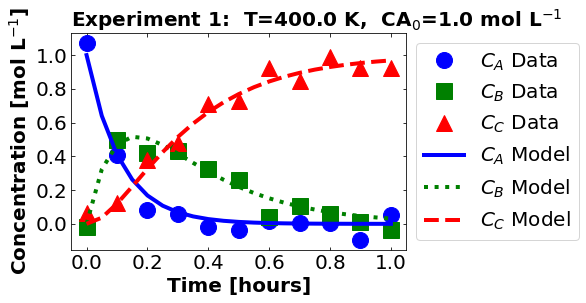

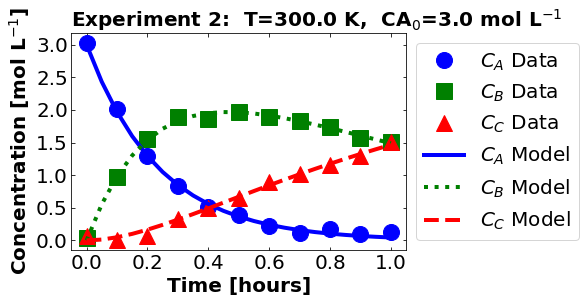

In [10]:
plot_data_and_model(theta_true, df)

## Perform Nonlinear Regression

We esimate the unknown model parameters from data by solving a (weighted) nonlinear regression problem.

\begin{equation}
\hat{\mathbf{\theta}} = \operatorname*{argmin}_{\underline{\theta}~\leq~\theta~\leq~\overline{\theta}} \sum_{d} \left(\mathbf{y}_d - f(\mathbf{\theta}, \mathbf{x}_d) \right)^\intercal \mathbf{W}_d \left(\mathbf{y}_d - f(\mathbf{\theta}, \mathbf{x}_d) \right)
\end{equation}

Here $y_d = C_{B,d}$ is the measured data, $\mathbf{f}(\cdot,\cdot)$ is the mathematical model, $\mathbf{\theta} = [A_1, A_2, E_1, E_2]$ are the regressed parameters, $\mathbf{x} = [C_{A0}, T, t]$ are the conditions for each data point (experiment) $d$, and $\mathbf{W} = \mathbf{I}$ is the weight matrix. For the code below, we are minimizing the sum of squared error using only data for $C_B$. 

### Solve Nonlinear Least Squares Problem

In [11]:
# nonlinear parameter estimation with full physics model
def regression_func(theta, data):
    '''
    Function to define regression function for least-squares fitting
    
    Note: This only uses CB measurements
    
    Arguments:
        theta: parameter vector
        data: Pandas data frame
    Returns:
        e: residual vector
    '''
    # determine number of entries in data frame
    n = len(data)

    # initialize matrix of residuals
    # rows: each row of Pandas data frame
    # columns: species CA, CB, CC
    e = np.zeros(n)

    # loop over experiments
    for i in data.exp.unique():

        # select the rows that correspond to the specific experiment number
        j = (data.exp == i)

        # determine experiment conditions
        CA0_ = float(data.CA0[j].mode())
        T_ = float(data.temp[j].mode())

        # determine experiment time
        t = data.time[j].to_numpy()

        CA, CB, CC = batch_rxn_model(theta,t,CA0_,T_)

        # Only use CB measurements
        e[j] = CB - data.CB[j]

    return e

Let's test our function.

In [12]:
e_test = regression_func(theta_true, df)
print(e_test)

[ 0.0173657  -0.02647976  0.08611161 -0.0152367  -0.01741918 -0.043441
  0.10923293 -0.00343846  0.00974479  0.03619475  0.06981694 -0.0346743
  0.00872662 -0.01749875 -0.06312433  0.08774574 -0.00580498  0.0246635
 -0.01057614 -0.02141178  0.03251863 -0.01876837]


Finally, we can compute the best fit estimate.

In [13]:
# Initial guess
theta0 = [85., 370., 7.5, 15]

# Bounds
bnds = ([50, 300, 5, 10,], [200, 400, 20, 50])

# Define function that includes data
my_func = lambda theta_ : regression_func(theta_, df)

# Perform nonlinear least squares
nl_results = optimize.least_squares(my_func, theta0, bounds=bnds, method='trf',verbose=2)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2477e-02                                    8.50e-02    
       1              2         2.2148e-02      3.30e-04       5.04e+00       8.77e-03    
       2              3         2.1796e-02      3.52e-04       2.12e+01       1.42e-02    
       3              4         2.1765e-02      3.15e-05       1.96e+00       3.07e-04    
       4              5         2.1732e-02      3.29e-05       2.52e+00       1.26e-04    
       5              6         2.1731e-02      1.05e-06       8.33e-02       1.68e-05    
       6              7         2.1731e-02      1.39e-08       1.25e-03       9.82e-08    
       7              8         2.1731e-02      9.37e-17       4.26e-06       2.79e-09    
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 2.2477e-02, final cost 2.1731e-02, first-order optimality 2.79e-09.


In [14]:
theta_hat = nl_results.x
print("theta_hat =",theta_hat)

theta_hat = [ 89.52352889 400.           7.62016597  15.17465026]


### Visualize Results

First let's plot the data and model predictions.

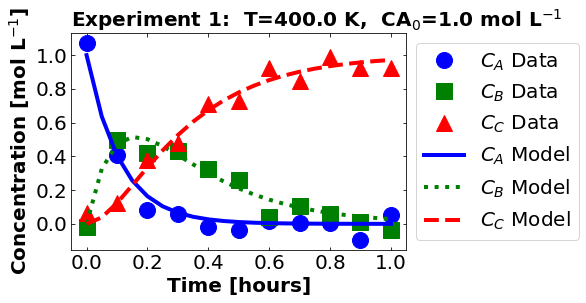

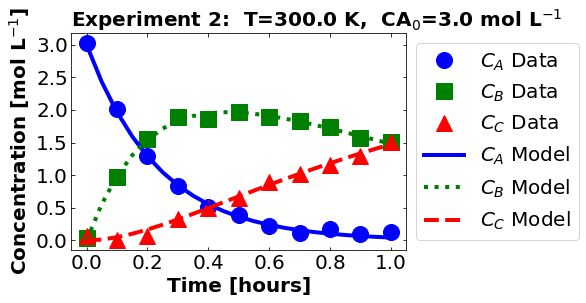

In [15]:
plot_data_and_model(theta_hat, df)

Next, let's look at the residuals. Recall, we only used $C_{B}$ in our regression formulation.

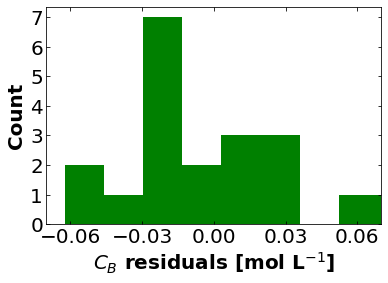

In [16]:
CB_residuals = regression_func(theta_hat, df)

# define font size
fs = 20

plt.hist(CB_residuals,color='green')
plt.xlabel("$C_{B}$ residuals [mol L$^{-1}$]",fontsize=fs,fontweight = 'bold')
plt.ylabel("Count",fontsize=fs,fontweight = 'bold')

# define tick size
plt.xlim((-0.07,0.07))
plt.xticks(fontsize=fs,ticks=np.arange(-0.06,0.07,0.03))
plt.yticks(fontsize=fs)
plt.tick_params(direction="in",top=True, right=True)

# finish plot
plt.show()

### Estimate Uncertainty

First let's estimate the variance of the residuals.

In [17]:
sigre = (CB_residuals.T @ CB_residuals)/(len(CB_residuals) - len(theta_hat))

How does the standard deviation of the residuals compare to the standard deviation of the measurement noise?

In [18]:
print("Estimated Standard Deviation of Residuals =",np.sqrt(sigre),"mol/L")
print("Standard Deviation of Measurement Error in Synthetic Data =",noise_std_dev,"mol/L")

Estimated Standard Deviation of Residuals = 0.049137624893656175 mol/L
Standard Deviation of Measurement Error in Synthetic Data = 0.05 mol/L


Estimating the covariance matrix using a linearization approximation is easy!

In [19]:
Sigma_theta = sigre * np.linalg.inv(nl_results.jac.T @ nl_results.jac)
print("Covariance matrix:\n",Sigma_theta)

Covariance matrix:
 [[ 2.77141940e+03 -9.72902361e+02  7.77883866e+01 -5.94859480e+00]
 [-9.72902361e+02  1.29273200e+04 -2.65789266e+01  8.23859555e+01]
 [ 7.77883866e+01 -2.65789266e+01  2.18854666e+00 -1.61348238e-01]
 [-5.94859480e+00  8.23859555e+01 -1.61348238e-01  5.28489135e-01]]


Recall the rows/colums are $A_1$, $A_2$, $E_1$, and $E_2$.

We can easily convert this to a correlation matrix.

In [20]:
corr_theta = Sigma_theta.copy()
for r in range(len(theta_hat)):
    for c in range(len(theta_hat)):
        corr_theta[r,c] = corr_theta[r,c]/np.sqrt(Sigma_theta[r,r])/np.sqrt(Sigma_theta[c,c])
        
print("Correlation matrix:\n",corr_theta)

Correlation matrix:
 [[ 1.         -0.16254136  0.99881656 -0.15543372]
 [-0.16254136  1.         -0.15801754  0.99673774]
 [ 0.99881656 -0.15801754  1.         -0.15002661]
 [-0.15543372  0.99673774 -0.15002661  1.        ]]


**Discussion:** Why are the pairs $A_1$, $E_2$ and $A_2$, $E_2$ highly correlated when measuring only $C_B$?

## Fisher Information Matrix

What is the value of measuring other physical quantities such as $C_A$ or $C_C$ in this example?

How can we systematically determine the most informative set of experiments?

The remainder of this notebook develops a mathematical framework to answer these (and related) questions.

### Model Sensitivity

The first step of calculating the Fisher Information Matrix (FIM) is computing the sensitivity of all model outputs to each model parameter.

In [21]:
def calc_model_output(theta_,data):
    '''
    Assembles matrix out model outputs (columns) by experimental conditions (rows)
    
    Arguments:
        theta_: values of theta parameters, numpy array
        data: data frame of experimental conditions
    
    Returns:
        model_output: matrix
    '''
    
    # Allocate matrix of model outputs
    model_output = np.zeros((len(data),3))
    
    # Iterate over rows in pandas dataframe (each row is an experiment)
    for i,r in data.iterrows():
        # Evaluate model and store results
        model_output[i,:] = batch_rxn_model(theta_, r.time, r.CA0, r.temp)
        
    return model_output

# Test function at nominal values
print(calc_model_output(theta_hat,df))

[[ 1.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 4.04359390e-01  4.71983465e-01  1.23657145e-01]
 [ 1.63506516e-01  5.01791382e-01  3.34702102e-01]
 [ 6.61153952e-02  4.07750121e-01  5.26134484e-01]
 [ 2.67343809e-02  2.99829192e-01  6.73436427e-01]
 [ 1.08102979e-02  2.10144215e-01  7.79045487e-01]
 [ 4.37124548e-03  1.43544280e-01  8.52084474e-01]
 [ 1.76755416e-03  9.66294369e-02  9.01603009e-01]
 [ 7.14727120e-04  6.44932646e-02  9.34792008e-01]
 [ 2.89006622e-04  4.28251919e-02  9.56885801e-01]
 [ 1.16862541e-04  2.83494368e-02  9.71533701e-01]
 [ 3.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 1.96746609e+00  9.83700121e-01  4.88337934e-02]
 [ 1.29030760e+00  1.54309287e+00  1.66599535e-01]
 [ 8.46212147e-01  1.83168855e+00  3.22099301e-01]
 [ 5.54964567e-01  1.94951127e+00  4.95524160e-01]
 [ 3.63957988e-01  1.96156445e+00  6.74477558e-01]
 [ 2.38691666e-01  1.90993601e+00  8.51372321e-01]
 [ 1.56539253e-01  1.82173268e+00  1.02172806e+00]
 [ 1.02661890e-01  1.71427939e+

We'll use finite difference to estimate the sensitivities.

In [22]:
def calc_model_sensitivity(theta_,data,verbose=False):
    '''
    Estimate the model sensitivity matrix using forward finite difference
    
    Arguments:
        model_function: Python function that computes model outputs
        theta_: nominal value of theta
        exp_design_df: data frame containing experimental data
    '''
    
    # Evaluate model at nominal point
    nominal_output = calc_model_output(theta_,data)
    
    # Extract number of experiments and number of measured/output variables
    (n_exp, n_output) = nominal_output.shape
    
    # Set finite difference step size
    eps = 1E-5
    
    # Extract number of parameters
    n_param = len(theta_)
    
    # Create list to store model sensitity matrices
    model_sensitivity = []
    
    # Loop over number of outputs
    for i in range(n_output):
        
        # Allocate empty sensitivty matrix
        model_sensitivity.append(np.zeros((n_exp,n_param)))
    
    # Loop over parameters
    for p in range(n_param):
        
        # Create perturbation vector
        perturb = np.zeros(n_param)
        perturb[p] = eps
        
        # Forward and backward perturbation simulations
        output_forward = calc_model_output(theta_ + perturb, data)
        output_backward = calc_model_output(theta_ - perturb, data)
        
        sensitivity = (output_forward - output_backward) / (2*eps)
        if verbose:
            print("\nparam ",p)
            print("sens:\n",sensitivity)
        
        # Loop over outputs
        for o in range(n_output):
            # Copy sensitivity results
            model_sensitivity[o][:,p] = sensitivity[:,o].copy()
    
    return model_sensitivity

model_sensitivity = calc_model_sensitivity(theta_hat, df)

print("CA sensitivity:\n",model_sensitivity[0])
print("CB sensitivity:\n",model_sensitivity[1])
print("CC sensitivity:\n",model_sensitivity[2])

CA sensitivity:
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.08973715e-03  0.00000000e+00  1.10087602e-01  0.00000000e+00]
 [-3.30744724e-03  0.00000000e+00  8.90299115e-02  0.00000000e+00]
 [-2.00609602e-03  0.00000000e+00  5.40001210e-02  0.00000000e+00]
 [-1.08157835e-03  0.00000000e+00  2.91139413e-02  0.00000000e+00]
 [-5.46682953e-04  0.00000000e+00  1.47156195e-02  0.00000000e+00]
 [-2.65267663e-04  0.00000000e+00  7.14047869e-03  0.00000000e+00]
 [-1.25140715e-04  0.00000000e+00  3.36853954e-03  0.00000000e+00]
 [-5.78306552e-05  0.00000000e+00  1.55668639e-03  0.00000000e+00]
 [-2.63074145e-05  0.00000000e+00  7.08143355e-04  0.00000000e+00]
 [-1.18196112e-05  0.00000000e+00  3.18160461e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.27138054e-03  0.00000000e+00  3.32756203e-01  0.00000000e+00]
 [-1.21607512e-02  0.00000000e+00  4.36457696e-01  0.00000000e+00]
 [-1.19629328e-02  0.00000000e+00  4.29357857

We are now ready to compute the FIM for each of the three measurements:

$$
M_{i} = (\sigma^{-2}_{i}) \mathbf{Q}_{i}^{T} \mathbf{Q}_{i} \quad \forall i \in \{C_A, C_B, C_C \}
$$

### FIM By Measurement Type

In [23]:
# Allocate list of FIM
FIM = []
measurements = ['CA','CB','CC']
for i in range(len(measurements)):
    FIM.append( 1/noise_std_dev**2 * model_sensitivity[i].T @ model_sensitivity[i])
    
    print("FIM for",measurements[i],"measurements:\n",FIM[i],"\n")

FIM for CA measurements:
 [[ 2.77135943e-01  0.00000000e+00 -9.82726797e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.82726797e+00  0.00000000e+00  3.49495231e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]] 

FIM for CB measurements:
 [[ 1.56846256e-01 -9.56610562e-03 -5.57644320e+00  1.55420093e+00]
 [-9.56610562e-03  1.21838382e-02  3.47843876e-01 -1.90081115e+00]
 [-5.57644320e+00  3.47843876e-01  1.98719040e+02 -5.63237399e+01]
 [ 1.55420093e+00 -1.90081115e+00 -5.63237399e+01  2.98442315e+02]] 

FIM for CC measurements:
 [[ 5.34873217e-02  2.49460063e-02 -1.85411508e+00 -3.88011717e+00]
 [ 2.49460063e-02  1.21838382e-02 -8.68404444e-01 -1.90081115e+00]
 [-1.85411508e+00 -8.68404444e-01  6.47801357e+01  1.36021753e+02]
 [-3.88011717e+00 -1.90081115e+00  1.36021753e+02  2.98442315e+02]] 



Discussion:
* What would measuring only $C_{A}$ only provide information about $A_1$ and $E_1$?
* If you could only choose to measure ONE species ($C_A$, $C_B$, or $C_C$), which would you choose and why?

### Combined FIM

Assuming the measurement errors across species are independent, we can compute a FIM for measuring all three species with simple addition.

In [24]:
FIM_total = FIM[0] + FIM[1] + FIM[2]
print(FIM_total)

[[ 4.87469521e-01  1.53799007e-02 -1.72578263e+01 -2.32591624e+00]
 [ 1.53799007e-02  2.43676764e-02 -5.20560568e-01 -3.80162230e+00]
 [-1.72578263e+01 -5.20560568e-01  6.12994406e+02  7.96980132e+01]
 [-2.32591624e+00 -3.80162230e+00  7.96980132e+01  5.96884631e+02]]


In [25]:
FIM.append(FIM_total)
measurements.append('all')

### Eigendecomposition

Next let us interpret the eigendecomposition of each FIM. For simplicity, we can going to drop the index $i$. Recall $\mathbf{M} \in \mathbb{R}^{m \times m}$ because $\mathbf{\theta} \in \mathbb{R}^{m}$.

\begin{equation}
\mathbf{M} = \mathbf{W} \mathbf{\Lambda} \mathbf{W}^{-1}, \quad \mathbf{W} = \begin{bmatrix} \mathbf{v}_{1} \cdots \mathbf{v}_{p} \end{bmatrix}, \quad \mathbf{\Lambda} = \begin{bmatrix} \lambda_1 & \cdots & 0 \\ \vdots & \ddots & \vdots \\ 0 & \cdots & \lambda_p \end{bmatrix} 
\end{equation} 

Here $\mathbf{W} \in \mathbb{R}^{m \times m}$ is the matrix of eigenvectors $\mathbf{v}_{1},\ldots,\mathbf{v}_{p}$ and $\mathbf{\Lambda} \in \mathbb{R}^{m \times m}$ is a diagonal matrix containing the corresponding eigenvalues $\lambda_1,\ldots,\lambda_p$. Because $\mathbf{M}$ is a [real symmetric matrix](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix#Real_symmetric_matrices) by definition, $\mathbf{W}^{-1} = \mathbf{W}^\intercal$, and the eigendecomposition can be written as follows:

\begin{equation}
\mathbf{M} = \sum_{k=1}^{p} \lambda_{k} \mathbf{v}_{k} \mathbf{v}_{k}^\intercal
\end{equation}

Now back to the example!


In [26]:
# Create empty dictionary to store eigendecompositions
eigendecompositions = {}

for i,m in enumerate(measurements):
    
    # Create empty matrix
    results_matrix = np.zeros((4,5))
    
    # Compute eigendecomposition
    w, v = linalg.eigh(FIM[i])
    
    print("**********\nConsidering measurement",measurements[i],"")
    for j in range(len(v)):
        print("\neigenvalue =",w[j])
        print("eigenvector:",v[:,j])
        
        # Store results
        results_matrix[j,0] = w[j]
        results_matrix[j,1:] = v[:,j]
        
    print("**********\n")
    
    eigendecompositions[m] = pd.DataFrame(results_matrix,columns=['eigenvalue','A1', 'A2', 'E1', 'E2'])

**********
Considering measurement CA 

eigenvalue = 0.0
eigenvector: [0. 1. 0. 0.]

eigenvalue = 0.0
eigenvector: [0. 0. 0. 1.]

eigenvalue = 0.0008076542403046005
eigenvector: [0.99960491 0.         0.02810742 0.        ]

eigenvalue = 349.77155897475797
eigenvector: [-0.02810742  0.          0.99960491  0.        ]
**********

**********
Considering measurement CB 

eigenvalue = 7.417670951499084e-05
eigenvector: [-0.094524    0.99549899 -0.0025974   0.0063425 ]

eigenvalue = 0.00036021877561471074
eigenvector: [9.95126558e-01 9.45571481e-02 2.79570296e-02 6.96125711e-04]

eigenvalue = 173.47263113156728
eigenvector: [ 0.02563466  0.00267488 -0.91127572 -0.41098938]

eigenvalue = 323.8573199861445
eigenvector: [ 0.01145476 -0.00579237 -0.41083844  0.9116178 ]
**********

**********
Considering measurement CC 

eigenvalue = 4.310703517123985e-06
eigenvector: [-0.38866152  0.92129245 -0.01127041  0.00595148]

eigenvalue = 0.0004773233523595857
eigenvector: [0.92086687 0.38882297 0.028

We can also see the eigenvalues in Pandas DataFrames.

In [27]:
for k in eigendecompositions:
    print("Eigendecomposition for measurement",k)
    print(eigendecompositions[k],"\n")

Eigendecomposition for measurement CA
   eigenvalue        A1   A2        E1   E2
0    0.000000  0.000000  1.0  0.000000  0.0
1    0.000000  0.000000  0.0  0.000000  1.0
2    0.000808  0.999605  0.0  0.028107  0.0
3  349.771559 -0.028107  0.0  0.999605  0.0 

Eigendecomposition for measurement CB
   eigenvalue        A1        A2        E1        E2
0    0.000074 -0.094524  0.995499 -0.002597  0.006342
1    0.000360  0.995127  0.094557  0.027957  0.000696
2  173.472631  0.025635  0.002675 -0.911276 -0.410989
3  323.857320  0.011455 -0.005792 -0.410838  0.911618 

Eigendecomposition for measurement CC
   eigenvalue        A1        A2        E1        E2
0    0.000004 -0.388662  0.921292 -0.011270  0.005951
1    0.000477  0.920867  0.388823  0.028617  0.001406
2    2.304915  0.028364 -0.001842 -0.908221  0.417524
3  360.982726 -0.011913 -0.005790  0.417358  0.908645 

Eigendecomposition for measurement all
   eigenvalue        A1        A2        E1        E2
0    0.000127 -0.136086  0.

### Covariance Matrix of Regressed Paramters

The covariance matrix $\mathbf{\Sigma_{\theta}}$ is approximately the inverse of the Fisher information matrix $\mathbf{M}$ (again dropping the measurement index $i$ for simplicity):

\begin{equation}
\mathbf{\Sigma_{\theta}} \approx \mathbf{M}^{-1} = \sigma^{2} \left(\mathbf{Q}^{\intercal} \mathbf{Q} \right)^{-1}
\end{equation}

What is we are able to measure the concentration of all of the species simultaneously? Under the assumption that the measurement errors are uncorrelated across measurement types, we can compute a total FIM as the sum of the contributions.

\begin{equation}
\mathbf{\Sigma_{\theta}} \approx \left(\sum_{i\in \mathcal{I}} \mathbf{M}_{i}^{-1} \right)^{-1} = \left( \sum_{i\in \mathcal{I}} \sigma_{i}^{2} \left(\mathbf{Q}_{i}^{\intercal} \mathbf{Q}_{i} \right) \right)^{-1}, \quad \mathcal{I} = \{C_{A}, C_{B}, C_{C} \}
\end{equation}


Now let's compute the covariance matrices (by measurement):

In [28]:
# Compute covariance matrices from FIM
cov_matrices = []
for m in range(len(FIM)):
    
    try:
        # Invert FIM
        cov = np.linalg.inv(FIM[m])
        print("Covariance matrix considering only measurement",measurements[m],"\n",cov,"\n")        
    except np.linalg.LinAlgError:
        # FIM is likely singular, skip printing
        print("Linear algebra error for measurement", measurements[m])
        cov = None
    cov_matrices.append(cov)

Linear algebra error for measurement CA
Covariance matrix considering only measurement CB 
 [[ 2.86955115e+03 -1.00735276e+03  8.05427561e+01 -6.15923775e+00]
 [-1.00735276e+03  1.33850558e+04 -2.75200852e+01  8.53031102e+01]
 [ 8.05427561e+01 -2.75200852e+01  2.26603983e+00 -1.67061677e-01]
 [-6.15923775e+00  8.53031102e+01 -1.67061677e-01  5.47202086e-01]] 

Covariance matrix considering only measurement CC 
 [[ 3.68190526e+04 -8.23154125e+04  1.07136010e+03 -5.33879033e+02]
 [-8.23154125e+04  1.97217257e+05 -2.38542446e+03  1.27310677e+03]
 [ 1.07136010e+03 -2.38542446e+03  3.15407239e+01 -1.56394151e+01]
 [-5.33879033e+02  1.27310677e+03 -1.56394151e+01  8.29883324e+00]] 

Covariance matrix considering only measurement all 
 [[ 7.51673028e+02 -9.80073759e+02  2.11273217e+01 -6.13409548e+00]
 [-9.80073759e+02  7.75216600e+03 -2.74077469e+01  4.92148384e+01]
 [ 2.11273217e+01 -2.74077469e+01  5.95490126e-01 -1.71746592e-01]
 [-6.13409548e+00  4.92148384e+01 -1.71746592e-01  3.1415903

How are the eigendecompositions of $\mathbf{M}$ and $\mathbf{\Sigma_{\theta}}$ related?
* Eigenvectors are the same
* Eigenvalues are inverses. If $\lambda_{k}$ is an eigenvalue of $\mathbf{M}$, then $\lambda_{k}^{-1}$ is an eigevalue of $\mathbf{\Sigma_{\theta}}$.

For simplicity in this notebook, $\lambda_{k}$ will always be an eigenvalue of $\mathbf{M}$.

We can also compute the correlation matrix:

In [29]:
n = len(theta_hat)

# Loop over the covariance matrices
for m in range(len(cov_matrices)):
    
    # Check that the matrix was not set to None (no linear algebra errors)
    if cov_matrices[m] is not None:
        # Grab covariance matrix
        cov = cov_matrices[m]
        
        # Create an emptry correlation matrix
        cor_matrix = np.zeros((n,n))
        # Loop over rows
        for i in range(n):
            # Loop over columns
            for j in range(n):
                # Normalize the covariance by the two variances (diagonal elements) to 
                # compute the correlation coefficint
                cor_matrix[i,j] = cov[i,j]/np.sqrt(cov[i,i]*cov[j,j])
        print("Correlation matrix for measurement",measurements[m],"\n",cor_matrix,"\n")

Correlation matrix for measurement CB 
 [[ 1.         -0.16254159  0.99881656 -0.15543403]
 [-0.16254159  1.         -0.15801776  0.99673774]
 [ 0.99881656 -0.15801776  1.         -0.15002692]
 [-0.15543403  0.99673774 -0.15002692  1.        ]] 

Correlation matrix for measurement CC 
 [[ 1.         -0.96598948  0.99417614 -0.96582411]
 [-0.96598948  1.         -0.95643924  0.99513924]
 [ 0.99417614 -0.95643924  1.         -0.96666537]
 [-0.96582411  0.99513924 -0.96666537  1.        ]] 

Correlation matrix for measurement all 
 [[ 1.         -0.40600627  0.99860257 -0.39917311]
 [-0.40600627  1.         -0.40338944  0.99726312]
 [ 0.99860257 -0.40338944  1.         -0.39707823]
 [-0.39917311  0.99726312 -0.39707823  1.        ]] 



### Visualizing Confidence Ellipses

Moreover, we can visualize the covariance matrix $\mathbf{\Sigma_{\theta}}$ as an elipitical confidence region were the axes of the ellipse at the eigenvectors $\mathbf{v}_{i}$ and the length of the axes are the eigenvalues $\lambda_{k}^{-1}$. The following code was adapted from this [excellent example](https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html) which is based on this [excellent explanation of the underlying linear algebra](https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html).

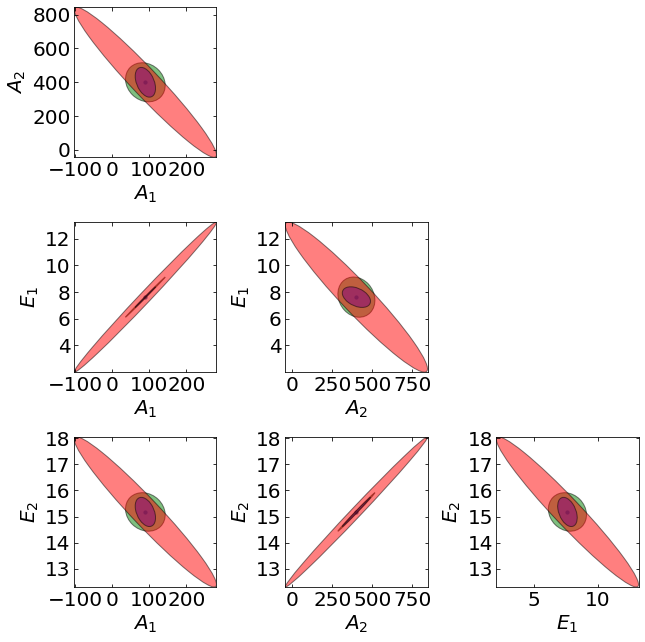

In [30]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

fig = plt.figure(figsize=(3*n,3*n))

# Define font size
fs=20

# Define colors for measurements
measurement_colors = ['blue','green','red','purple']

# Number of standard deviations for confidence ellipses
n_std = 1

# Define names of parameters
theta_labels = ['$A_1$', '$A_2$', '$E_1$', '$E_2$']


# Loop over rows
for i in range(0,n):
    # Loop over columns -- subdiagonal
    for j in range(i+1,n):

        # Create subplots below the diagonal
        plt.subplot(n,n,i+n*j+1)
        
        # Plot theta estimate
        plt.scatter(theta_hat[i],theta_hat[j],s=10)
        plt.xlabel(theta_labels[i],fontsize=fs,fontweight='bold')
        plt.ylabel(theta_labels[j],fontsize=fs,fontweight='bold')
        
        # define tick size
        plt.xticks(fontsize=fs)
        plt.yticks(fontsize=fs)
        plt.tick_params(direction="in",top=True, right=True)
        
        max_scale_x = 0
        max_scale_y = 0
        
        # loop over measurements
        for m in range(len(FIM)):
            
            # Check not None
            if cov_matrices[m] is not None:
            
                # Select rows from cov
                rows = cov_matrices[m][(i,j),:]

                # Select columns from FIM
                cov = rows[:,(i,j)]
            
                # Draw non-dimensionalized
                pearson = cov[0,1]/np.sqrt(cov[0,0]*cov[1,1])
                ell_radius_x = np.sqrt(1 + pearson)
                ell_radius_y = np.sqrt(1 - pearson)
                ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                                      edgecolor='k',facecolor=measurement_colors[m],alpha=0.5)

                # Calculating the standard deviation of x from
                # the squareroot of the variance and multiplying
                # with the given number of standard deviations.
                scale_x = np.sqrt(cov[0, 0]) * n_std

                # calculating the standard deviation of y
                scale_y = np.sqrt(cov[1, 1]) * n_std

                # transforming ellipse
                transf = transforms.Affine2D() \
                    .rotate_deg(45) \
                    .scale(scale_x, scale_y) \
                    .translate(theta_hat[i], theta_hat[j])
                
                # Plot ellipse
                ax = plt.gca()
                ellipse.set_transform(transf + ax.transData)
                ax.add_patch(ellipse)
                
                # Keep track of limits
                max_scale_x = np.max([scale_x,max_scale_x])
                max_scale_y = np.max([scale_y,max_scale_y])
        
        # Adjust plot limits
        plt.xlim([theta_hat[i] - max_scale_x, theta_hat[i] + max_scale_x])
        plt.ylim([theta_hat[j] - max_scale_y, theta_hat[j] + max_scale_y])
        
plt.tight_layout()

The above plot shows the projected confidence ellipses considering only measurment $C_B$ (green), only measurement $C_C$ (red), and all measurments (purple). With only measurment $C_A$, the Fisher information is not invertable and the covariance matrix is not defined, hence there is no blue ellipse.

### Discussion
1. Why are the red ellipses (measurement $C_C$ only) the largest?
2. Why are the purple ellipses (all measurements) the smallest?
3. Why are some ellipses so skinny?
4. Why are the ellipses tilted? Why do some have a positive tilt and others have a negative tilt?

### Model Identifiability

If model predictions $\mathbf{f}(\mathbf{x}_d,\mathbf{\theta})$ are insensitivite to $\mathbf{\theta}_j$, then:
* Sensitivity matrix $\mathbf{Q}$, Fisher information $\mathbf{M}$, and the covariance $\mathbf{\Sigma_\theta}$ matrices are (numerically) rank deficient
* At least one one eigenvalue of $\mathbf{M}$ is (near-)zero and it's corresponding eigenvector predominently points in the direction of $\theta_j$
* The data $\mathbf{x}$ and $\mathbf{y}$ cannot uniquely identify $\theta_j$ in model $\mathbf{f}$
* There is large uncertainty in $\theta_j$ (and corresponding elements of the covariance matrix $\mathbf{\Sigma_\theta}$)

Practical steps to overcome model identifiability:
1. Interpret the eigenvectors. Reformulate the model to remove any redundant parameters. For example, one cannot uniquely estimate $\theta_1 \cdot \theta_2$ but may be able to estimate a new lumped parameter $\theta_3 := \theta_1 \cdot \theta_2$ instead of the two original parameters.
2. Fix non-identifiable (a.k.a., sloppy) parameters based on literature and other prior information
3. Using your model and Fisher information matrix analysis, determine if measuring other physical quantities would make your model identifiable.

### Optimality metrics

In [31]:
def optimality_metrics(FIM, verbose=True):
    ''' Compute optimality metrics using eigenvalues
    
    Arguments:
        FIM: numpy array
        
    Returns:
        dopt, aopt, eopt (float)
    
    '''
    
    # Compute eigendecomposition
    # Compute eigendecomposition
    eigenvalues, eigenvectors = linalg.eigh(FIM)
    
    # Determinant 
    dopt = np.product(eigenvalues)
    
    # Trace
    aopt = np.sum(eigenvalues)
    
    # Min eigenvalue
    eopt = np.min(eigenvalues)
    
    if verbose:
        print("D-optimality =",dopt)
        print("A-optimality =",aopt)
        print("E-optimality =",eopt)
    
    return dopt, aopt, eopt

for i in range(len(measurements)):
    print("**********\nConsidering measurement",measurements[i],"")
    optimality_metrics(FIM[i],True)
    print("**********\n")

**********
Considering measurement CA 
D-optimality = 0.0
A-optimality = 349.77236662899827
E-optimality = 0.0
**********

**********
Considering measurement CB 
D-optimality = 0.0015011309979356335
A-optimality = 497.3303855131969
E-optimality = 7.417670951499084e-05
**********

**********
Considering measurement CC 
D-optimality = 1.711993579475809e-06
A-optimality = 363.28812237159497
E-optimality = 4.310703517123985e-06
**********

**********
Considering measurement all 
D-optimality = 0.07387886756768279
A-optimality = 1210.3908745137921
E-optimality = 0.00012678747681498252
**********



## What is the next best experiment?

In [32]:
temperatures = np.linspace(300, 550, 26)
intial_concentrations = np.linspace(1,5,11)

# Allocate lists and empty arrays
Dopt = []
Aopt = []
Eopt = []
for k in range(len(measurements)):
    empty_matrix = np.zeros((len(temperatures),len(intial_concentrations)))
    Dopt.append(empty_matrix)
    Aopt.append(empty_matrix.copy())
    Eopt.append(empty_matrix.copy())

# Loop over proposed temperatures
for i,T in enumerate(temperatures):
    # Loop over proposed concentrations
    for j,C in enumerate(intial_concentrations):
        
        # Create df for new experiment
        exp3 = np.zeros((n_time,4))

        # Assign 3 to column 0. This is the experiment number.
        exp3[:,0] = 3

        # Copy C into column 1
        exp3[:,1] = C.copy()

        # Copy T into column 2 
        exp3[:,2] = T.copy()

        # Copy time data into column 3
        exp3[:,3] = time_exp
           
        # Create dataframe for new experiments
        new_df = pd.DataFrame(exp3, columns=['exp', 'CA0','temp','time'])
             
        # Calculate model sensitivities
        model_sensitivity = calc_model_sensitivity(theta_hat, new_df)
        
        # Allocate empty matrix for combined measurements
        FIM_new_all = np.zeros((n,n))
        
        # Loop over measurements
        for k in range(len(measurements)):
            
            # Skip "all" measuremnt 
            if k < len(measurements)-1:
            
                # Compute FIM of proposed experiment
                FIM_new = 1/noise_std_dev**2 * model_sensitivity[k].T @ model_sensitivity[k]
                
                # Add to total
                FIM_new_all += FIM_new
            
            # All measurements
            else:
                FIM_new = FIM_new_all
            
    
            # Compute total FIM (prior + new)
            FIM_total = FIM[k] + FIM_new
                        
            # Compute A and D-optimality
            Dopt[k][i,j] = np.linalg.det(FIM_total)
            Aopt[k][i,j] = np.trace(FIM_total)
            
            # Compute E-optimality
            smallest_eigenvalue = linalg.eigh(FIM_total, eigvals_only=True, subset_by_index=[0, 0])
            Eopt[k][i,j] = smallest_eigenvalue[0]

Let's make a function that visualizes the MBDoE metrics as a heatmap.

In [33]:
def create_contour_plot(matrix, zlabelstring, clabel_fmt="%2.2f",x=temperatures, y=intial_concentrations):
    # draw figure, using (6,6) because the plot is small otherwise
    plt.figure(figsize=(6,6))
    
    # define font size
    fs = 20

    # plot heatmap
    #   cmap defines the overall color within the heatmap 
    #   levels: determines the number and positions of the contour lines / regions.
    cs = plt.contourf(x, y, matrix,cmap=cm.coolwarm, levels=100)

    # plot color bar
    cbar = plt.colorbar(cs)

    # plot title in color bar
    cbar.ax.set_ylabel(zlabelstring, fontsize=fs, fontweight='bold')

    # set font size in color bar
    cbar.ax.tick_params(labelsize=fs)

    # plot equipotential line
    #  [::10] means sampling 1 in every 10 samples
    #  colors define the color want to use, 'k' for black
    #  alpha is blending value, between 0 (transparent) and 1 (opaque).
    #  linestyle defines the linestyle.
    #  linewidth defines the width of line
    cs2 = plt.contour(cs, levels=cs.levels[::15], colors='k', alpha=0.7, linestyles='dashed', linewidths=3)

    # plot the heatmap label
    #  %2.2f means keep to 2 digit
    #  fontsize defines the size of the text in figure
    plt.clabel(cs2, fmt=clabel_fmt, colors='k', fontsize=fs)

    # define tick size
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.tick_params(direction="in",top=True, right=True)

    # set squared figure
    # plt.axis('square')
    
    # Plot data from previous two experiments
    plt.plot([T_exp1, T_exp2], [CA0_exp1, CA0_exp2], marker='*', markersize=20, color='k', linestyle="")

    # plot titile and x,y label
    plt.xlabel("Temperature [K]", fontsize=fs, fontweight='bold')
    plt.ylabel("Initial Concentration [mol L$^{-1}$]", fontsize=fs, fontweight='bold')
    plt.show()

### A-Optimality

We'll start by plotting A-optimality seperately for each of the three measurement types. The stars mark the prior two experiments. The colored contours show metrics of the FIM depending $T$ and $C_{A0}$ for the third experiment. 

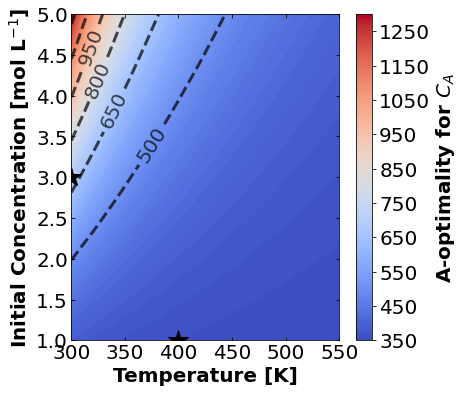

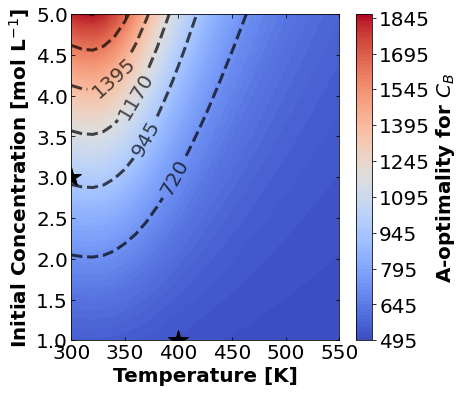

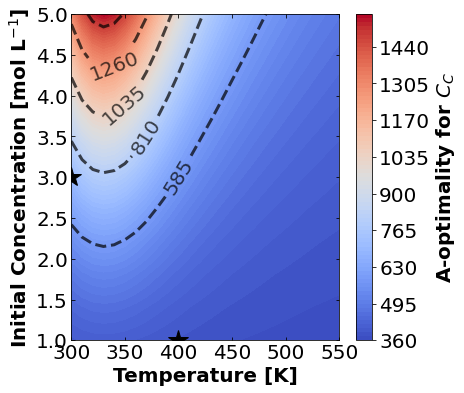

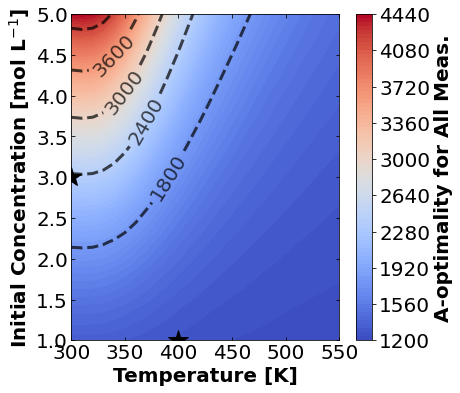

In [34]:
measurements_labels = ['$C_{A}$','$C_{B}$','$C_{C}$','All Meas.']
for k,m in enumerate(measurements_labels):
    create_contour_plot(Aopt[k].transpose(), "A-optimality for "+m, "%2.0f")

### D-Optimality

Likewise, let's make plots for D-optimality.

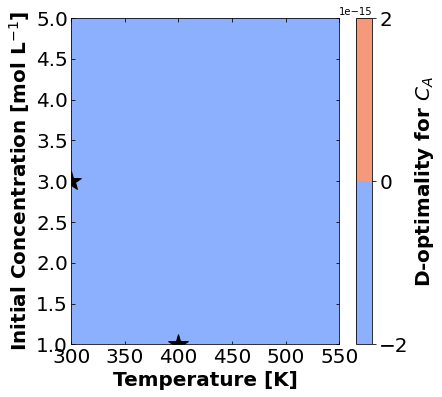

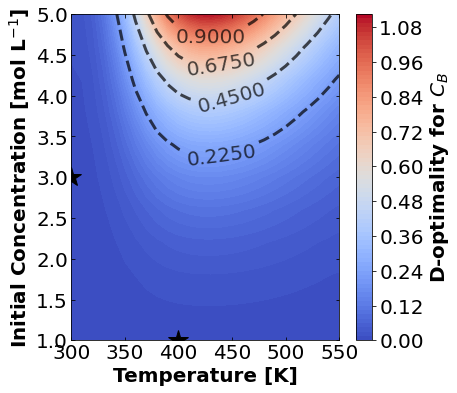

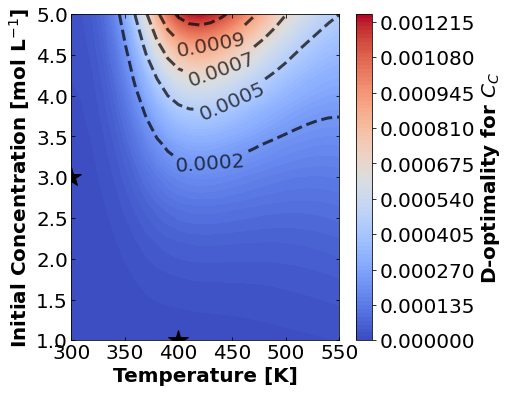

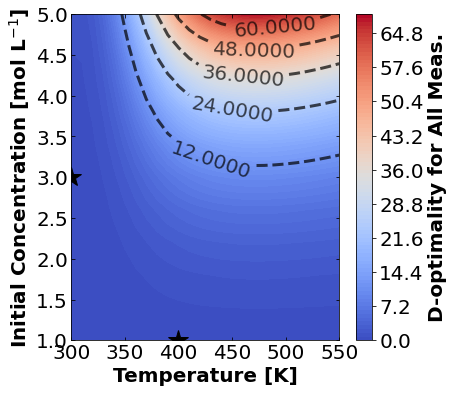

In [35]:
for k,m in enumerate(measurements_labels):
    create_contour_plot(Dopt[k].transpose(), "D-optimality for "+m, "%2.4f")

### E-Optimality

And finally E-optimality.

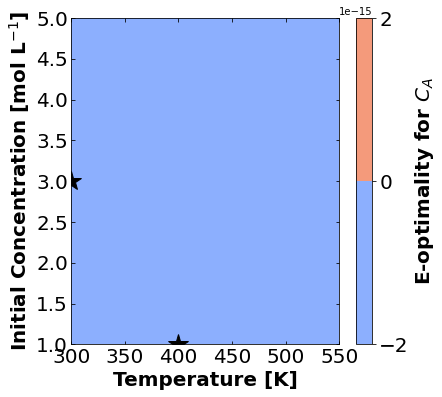

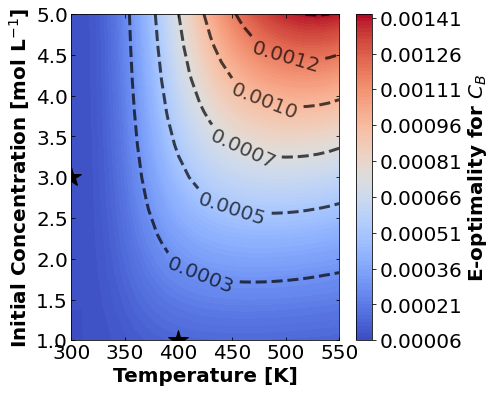

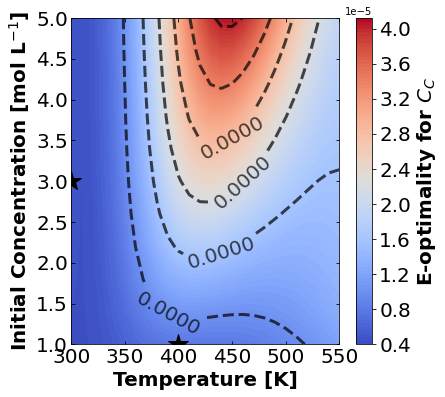

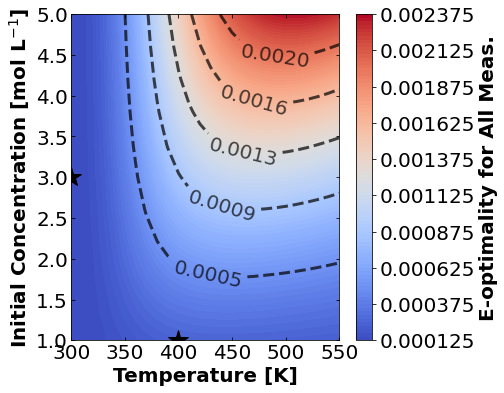

In [36]:
for k,m in enumerate(measurements_labels):
    create_contour_plot(Eopt[k].transpose(), "E-optimality for "+m, "%2.4f")

### Discussion

* Based on the plots for D-, A-, and E-optimality, why is it a bad idea to only measure $C_{A}$? Using the mathematical model for the experiment, explain why this makes sense.
* Why are D- and E-optimality one or more orders of magnitude larger for measuring $C_{B}$ instead of $C_{C}$?
* Why do D- and E-optimality both recommend a third experiment at the maximum value for $C_{A0}$? Using the mathematical model and assumed measurement error structure, explain why this makes sense.
* Why do A-, D-, and E-optimality recommend a third experiment at low, medium, and high temperatures, respectively? Which one should we choose if we can only do one more experiment?

## Take Away Messages

* Fisher information matrix quantifies the value of data in the context of a mathematical model
* An eigendecomposition of the Fisher information matrix reveals which parameters are (locally) not identiafiable
* A-, D-, and E-optimality help inform which experimental conditions and measurements are most informative
* Heatmaps of these optimality matrics help build intuition about the model

## Recommended Reading

**Review:**

Franceschini, Gaia, and Sandro Macchietto. [Model-based design of experiments for parameter precision: State of the art](https://www.sciencedirect.com/science/article/pii/S0009250907008871) *Chemical Engineering Science* 63.19 (2008): 4846-4872.

**Software:**

Wang, Jialu, and Alexander W. Dowling. [Pyomo.DoE: An open‐source package for model‐based design of experiments in Python](https://aiche.onlinelibrary.wiley.com/doi/full/10.1002/aic.17813) *AIChE Journal* 68.12 (2022): e17813.

**Applications at Notre Dame:**

Ouimet, Jonathan A., et al. [DATA: Diafiltration Apparatus for high-Throughput Analysis](https://www.sciencedirect.com/science/article/pii/S0376738821006888) *Journal of Membrane Science* 641 (2022): 119743.

Ghosh, Kanishka, Sergio Vernuccio, and Alexander W. Dowling. [Nonlinear Reactor Design Optimization With Embedded Microkinetic Model Information](https://www.frontiersin.org/articles/10.3389/fceng.2022.898685/full) *Frontiers in Chemical Engineering* 4 (2022): 898685.

Liu, Xinhong, et al. [Accelerating Membrane Characterization with Model-Based Design of Experiments](https://dowlinglab.nd.edu/assets/449451/pse2021_diafiltration_doe_paper_vf_preprint.pdf) *Computer Aided Chemical Engineering* 49 (2022): 859-864.

Liu, Xinhong, et al. [Mathematical Modelling of Reactive Inks for Additive Manufacturing of Charged Membranes](https://dowlinglab.nd.edu/assets/478074/pse2021_reactive_ink_preprint.pdf) *Computer Aided Chemical Engineering* 49 (2022): 1063-1068.

Garciadiego, Alejandro, et al. [What data are most valuable to screen ionic liquid entrainers for hydrofluorocarbon refrigerant reuse and recycling?](https://chemrxiv.org/engage/api-gateway/chemrxiv/assets/orp/resource/item/6299694a468a08331949d774/original/what-data-are-most-valuable-to-screen-ionic-liquid-entrainers-for-hydrofluorocarbon-refrigerant-reuse-and-recycling.pdf) *Industrial \& Engineering Chemistry Research* accepted (2022).
